In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from pathlib import Path
import os

# --- Configuration et Donn√©es ---
Cible = 'conso_5_usages_ef'
RANDOM_SEED = 42
Run = 10

In [18]:
#On apporte les donn√©e 
df = pd.read_csv(r'C:\Users\gopit\OneDrive\Documents\MASTER2SISE\m2_Enedis\m2_enedis\Dataset_Model\donnees_ml_preparees.csv', sep=',')

In [4]:
#Variable a standardis√© 
Standardiser_Variables = ['hauteur_sous_plafond', 'surface_habitable_logement']

# Colonnes cat√©gorielles/bool√©ennes (d√©j√† encod√©es) √† utiliser telles quelles
Colonne_Utilises = [
    'qualite_isolation_murs', 'etiquette_dpe', 'periode_construction', 'nombre_appartement_cat', 'type_batiment_immeuble', 
    'type_batiment_maison', 'type_energie_principale_chauffage_Charbon', 'type_energie_principale_chauffage_Fioul', 
    'type_energie_principale_chauffage_Gaz (GPL/Propane/Butane)', 'type_energie_principale_chauffage_Gaz naturel', 
    'type_energie_principale_chauffage_R√©seau de chauffage urbain', 'type_energie_principale_chauffage_√âlectricit√©', 
    'type_energie_n1_Charbon', 'type_energie_n1_Fioul', 'type_energie_n1_Gaz (GPL/Propane/Butane)', 
    'type_energie_n1_Gaz naturel', 'type_energie_n1_R√©seau de chauffage urbain', 'type_energie_n1_√âlectricit√©', 'logement_neuf'
]

Exclure = ['conso_5_usages_ef_energie_n1','cout_total_5_usages','cout_total_5_usages_energie_n1']

In [5]:
Toutes_Donnees = Standardiser_Variables + Colonne_Utilises

In [6]:
# Convertir les bool√©ens en entiers (si ce n'est pas d√©j√† fait)
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

# D√©finir les features (X) et la cible (y)
X = df.drop([Cible] + Exclure, axis=1, errors='ignore')
y = df[Cible]

# S'assurer que X ne contient que les colonnes n√©cessaires, dans le bon ordre
X = X[Toutes_Donnees]

print(f"Nombre total d'observations apr√®s chargement: {len(df)}")
print(f"Nombre de variables du mod√®le: {X.shape[1]}")

Nombre total d'observations apr√®s chargement: 1043068
Nombre de variables du mod√®le: 21


In [7]:
print("\nMod√®le : R√©gression Lin√©aire Standard")
print(f"√âvaluation de la stabilit√© du mod√®le sur {Run} splits al√©atoires (80/20)...")

stability_metrics = []

# Initialisation des transformateurs (ils seront fit_transform√© √† chaque it√©ration)
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
model = LinearRegression()

# === INITIALISATION DES VARIABLES POUR LE STOCKAGE DU DERNIER RUN (CRUCIAL) ===
y_test_run_last = None
y_pred_run_last = None
X_test_run_last = None # Ajout pour la Matrice de Confusion future

for i in range(1, Run + 1):
    
    # 1. Split des donn√©es
    X_train_run, X_test_run, y_train_run, y_test_run = train_test_split(
        X, y, test_size=0.3, random_state=RANDOM_SEED + i
    )
    
    # S√©parer les colonnes √† scaler
    X_train_scale = X_train_run[Standardiser_Variables]
    X_test_scale = X_test_run[Standardiser_Variables]
    
    # 2. Imputation 
    X_train_scale_imputed = imputer.fit_transform(X_train_scale)
    X_test_scale_imputed = imputer.transform(X_test_scale)
    
    # 3. Standardisation 
    X_train_scaled = scaler.fit_transform(X_train_scale_imputed)
    X_test_scaled = scaler.transform(X_test_scale_imputed)
    
    # 4. Reconstruction des ensembles (Concat√©ner les features standardis√©es et les features pass-through)
    
    # Features "Passthrough" (d√©j√† trait√©es/encod√©es)
    X_train_passthrough = X_train_run[Colonne_Utilises].values
    X_test_passthrough = X_test_run[Colonne_Utilises].values

    # Ensemble final pour l'entra√Ænement (Num√©rique Scal√© + Passthrough)
    X_train_final = np.hstack((X_train_scaled, X_train_passthrough))
    X_test_final = np.hstack((X_test_scaled, X_test_passthrough))

    # 5. Entra√Ænement et Pr√©diction du Mod√®le
    model.fit(X_train_final, y_train_run)
    y_pred_run = model.predict(X_test_final)

    # === SAUVEGARDE DU DERNIER RUN (Run 10) ===
    if i == Run:
        y_test_run_last = y_test_run
        y_pred_run_last = y_pred_run
        X_test_run_last = X_test_run
    
    # 6. Calcul des M√©triques
    mse = mean_squared_error(y_test_run, y_pred_run)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_run, y_pred_run)
    
    stability_metrics.append({'run': i, 'R2': r2, 'RMSE': rmse})
    print(f"Run {i}/{Run}: R2={r2:.4f}, RMSE={rmse:.2f}")


Mod√®le : R√©gression Lin√©aire Standard
√âvaluation de la stabilit√© du mod√®le sur 10 splits al√©atoires (80/20)...
Run 1/10: R2=0.7786, RMSE=2798.53
Run 2/10: R2=0.7803, RMSE=2786.73
Run 3/10: R2=0.7778, RMSE=2798.76
Run 4/10: R2=0.7808, RMSE=2780.48
Run 5/10: R2=0.7794, RMSE=2788.00
Run 6/10: R2=0.7779, RMSE=2790.84
Run 7/10: R2=0.7782, RMSE=2798.60
Run 8/10: R2=0.7785, RMSE=2788.28
Run 9/10: R2=0.7788, RMSE=2783.82
Run 10/10: R2=0.7782, RMSE=2797.28


In [8]:
results_df = pd.DataFrame(stability_metrics)

print("\n" + "="*50)
print("R√âSUM√â DE LA STABILIT√â DU MOD√àLE (R√©gression Lin√©aire)")
print("="*50)
print(f"Meilleur R2 : {results_df['R2'].max():.4f}")
print(f"Pire R2   : {results_df['R2'].min():.4f}")
print(f"R2 Moyen  : {results_df['R2'].mean():.4f}")
print(f"√âcart Type R2 : {results_df['R2'].std():.4f}")

# Affichage des coefficients du dernier mod√®le entra√Æn√© (pour interpr√©tation)
print("\nCoefficients du dernier mod√®le entra√Æn√© (Standardis√©s):")

# R√©cup√©rer l'ordre des colonnes apr√®s transformation
feature_names = Standardiser_Variables + Colonne_Utilises


R√âSUM√â DE LA STABILIT√â DU MOD√àLE (R√©gression Lin√©aire)
Meilleur R2 : 0.7808
Pire R2   : 0.7778
R2 Moyen  : 0.7788
√âcart Type R2 : 0.0010

Coefficients du dernier mod√®le entra√Æn√© (Standardis√©s):


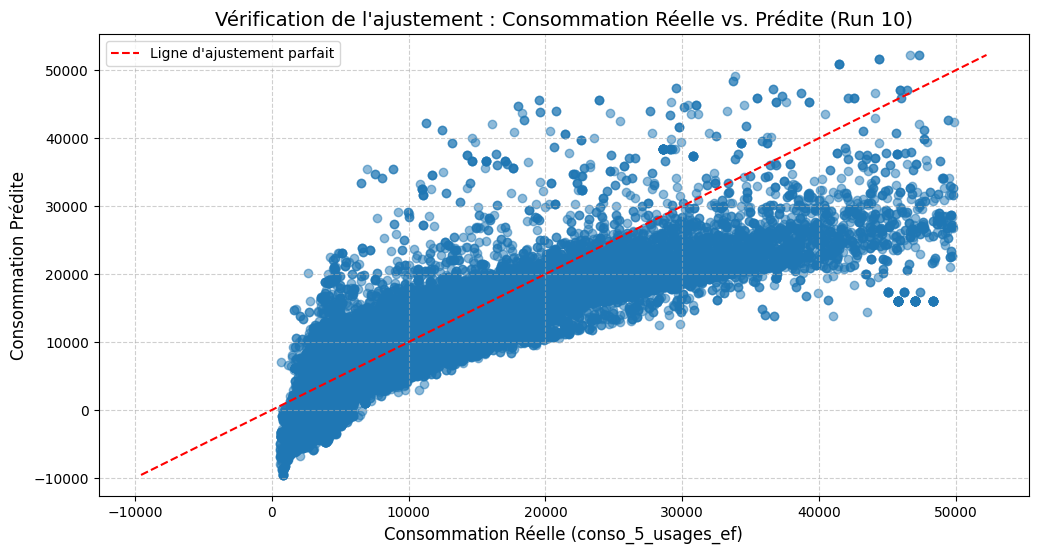

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
plt.scatter(y_test_run_last, y_pred_run_last, alpha=0.5)

# Ligne de r√©f√©rence y=x (o√π les pr√©dictions parfaites devraient se trouver)
# D√©termination des limites des axes pour s'assurer que la ligne rouge est visible
max_val = max(y_test_run_last.max(), y_pred_run_last.max())
min_val = min(y_test_run_last.min(), y_pred_run_last.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ligne d\'ajustement parfait')

plt.title('V√©rification de l\'ajustement : Consommation R√©elle vs. Pr√©dite (Run 10)', fontsize=14)
plt.xlabel(f'Consommation R√©elle ({Cible})', fontsize=12)
plt.ylabel(f'Consommation Pr√©dite', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [13]:
# ====================================================================
# CELL 3: Split Initial & Pr√©traitement de Base (Pr√©paration GridSearch)
# ====================================================================

print("\n--- Pr√©traitement et Split initial pour GridSearch ---")

# Split initial (80% Train, 20% Test)
# X et y doivent avoir √©t√© d√©finis dans la CELL 2
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_SEED
)

# Nous utiliserons y_train_raw comme cible pour le GridSearch sur les donn√©es brutes
y_target_gs = y_train_raw


# --- 1. Imputation (Fit sur Train) ---
imputer_gs = SimpleImputer(strategy='mean')
# Imputer toutes les colonnes √† standardiser
X_train_imputed = imputer_gs.fit_transform(X_train_raw[Standardiser_Variables])

# --- 2. Standardisation (Fit sur Train) ---
scaler_gs = StandardScaler()
# Standardiser les colonnes imput√©es
X_train_scaled = scaler_gs.fit_transform(X_train_imputed)

# --- 3. Reconstruction de la Matrice d'Entra√Ænement ---
# Colonnes Passthrough (d√©j√† encod√©es)
X_train_passthrough = X_train_raw[Colonne_Utilises].values

# X_train_final sera la matrice d'entra√Ænement pr√©trait√©e pour le GridSearch
X_train_final = np.hstack((X_train_scaled, X_train_passthrough))

print(f"Taille du jeu d'entra√Ænement final (pour GridSearch): {X_train_final.shape}")


--- Pr√©traitement et Split initial pour GridSearch ---
Taille du jeu d'entra√Ænement final (pour GridSearch): (730147, 21)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Import des mod√®les de r√©gression r√©gularis√©e
from sklearn.linear_model import Ridge, Lasso, LinearRegression 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# ====================================================================
# CELL 4: GridSearch pour Ridge et Lasso (Recherche de alpha)
# ====================================================================

print("\n--- GridSearch pour optimiser Ridge et Lasso (Cible Brute) ---")
param_grid = {'alpha': [0.0, 0.1, 1.0, 10.0, 100.0, 500.0, 1000.0]} 


y_target_gs = y_train_raw #

best_model = None
best_score = -np.inf 
best_name = ""

# A. GridSearch pour Ridge
ridge_model = Ridge(random_state=RANDOM_SEED)
# Utiliser n_jobs=1 pour √©viter le MemoryError que vous avez rencontr√©
grid_ridge = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=1, verbose=1)
grid_ridge.fit(X_train_final, y_target_gs)

print("\nR√©sultat Ridge:")
print(f"Meilleur alpha pour Ridge: {grid_ridge.best_params_['alpha']:.4f}")

if grid_ridge.best_score_ > best_score:
    best_score = grid_ridge.best_score_
    best_model = grid_ridge.best_estimator_
    best_name = "Ridge"

# --- B. GridSearch pour Lasso ---
lasso_model = Lasso(random_state=RANDOM_SEED, max_iter=5000)
grid_lasso = GridSearchCV(lasso_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=1, verbose=1)
grid_lasso.fit(X_train_final, y_target_gs)

print("\nR√©sultat Lasso:")
print(f"Meilleur alpha pour Lasso: {grid_lasso.best_params_['alpha']:.4f}")

if grid_lasso.best_score_ > best_score:
    best_score = grid_lasso.best_score_
    best_model = grid_lasso.best_estimator_
    best_name = "Lasso"

print(f"\n Le meilleur mod√®le global est: {best_name} (avec MSE de {-best_score:.4f})")


--- GridSearch pour optimiser Ridge et Lasso (Cible Brute) ---
Fitting 5 folds for each of 7 candidates, totalling 35 fits

R√©sultat Ridge:
Meilleur alpha pour Ridge: 10.0000
Fitting 5 folds for each of 7 candidates, totalling 35 fits


c:\Users\gopit\OneDrive\Documents\MASTER2SISE\m2_Enedis\env-m2ENEDIS\Lib\site-packages\sklearn\base.py:1365: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\gopit\OneDrive\Documents\MASTER2SISE\m2_Enedis\env-m2ENEDIS\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\gopit\OneDrive\Documents\MASTER2SISE\m2_Enedis\env-m2ENEDIS\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.590e+12, tolerance: 2.349e+09
Linear regression models with a zero l1 penalization strength are more efficiently fi

In [ ]:
# ====================================================================
# CELL 5: Test de Stabilit√© (Validation Crois√©e 10 Runs)
# ====================================================================

# üö® D√âFINITION  MEILLEUR MOD√àLE (Bas√© sur le GridSearch et Ridge)
# Nous utilisons Ridge avec l'alpha trouv√© (10.0) car Lasso a rencontr√© des probl√®mes de convergence.

from sklearn.linear_model import Ridge
best_model_name = "Ridge"
best_model = Ridge(alpha=10.0, random_state=RANDOM_SEED)


print(f"\n--- Test de Stabilit√© pour le meilleur mod√®le ({best_model_name}, alpha=10.0) ---")
print(f"√âvaluation sur {Run} splits al√©atoires (30% test)...")

stability_metrics = []

# R√©initialiser les transformateurs
imputer_stab = SimpleImputer(strategy='mean')
scaler_stab = StandardScaler()

# Initialisation des variables pour le stockage du dernier run (Crucial)
y_test_run_last = None
y_pred_run_last = None
X_test_run_last = None

for i in range(1, Run + 1):
    
    # 1. Split des donn√©es 
    X_train_stab, X_test_stab, y_train_stab, y_test_stab = train_test_split(
        X, y, test_size=0.3, random_state=RANDOM_SEED + i
    )
    
    # Pr√©traitement complet du nouveau split
    X_train_scale_stab = X_train_stab[Standardiser_Variables]
    X_test_scale_stab = X_test_stab[Standardiser_Variables]
    
    # Imputation et Standardisation
    imputer_stab.fit(X_train_scale_stab)
    X_train_imputed_stab = imputer_stab.transform(X_train_scale_stab)
    X_test_imputed_stab = imputer_stab.transform(X_test_scale_stab)

    scaler_stab.fit(X_train_imputed_stab)
    X_train_scaled_stab = scaler_stab.transform(X_train_imputed_stab)
    X_test_scaled_stab = scaler_stab.transform(X_test_imputed_stab)
    
    # Reconstruction des ensembles
    X_train_final_stab = np.hstack((X_train_scaled_stab, X_train_stab[Colonne_Utilises].values))
    X_test_final_stab = np.hstack((X_test_scaled_stab, X_test_stab[Colonne_Utilises].values))

    # 4. Entra√Ænement et Pr√©diction (Cible Brute)
    best_model.fit(X_train_final_stab, y_train_stab)
    y_pred_run_stab = best_model.predict(X_test_final_stab)
    
    # 5. Stockage du Dernier Run
    if i == Run:
        y_test_run_last = y_test_stab
        y_pred_run_last = y_pred_run_stab
        X_test_run_last = X_test_stab
    
    # 6. Calcul des M√©triques
    mse = mean_squared_error(y_test_stab, y_pred_run_stab)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_stab, y_pred_run_stab)
    
    stability_metrics.append({'run': i, 'R2': r2, 'RMSE': rmse})
    print(f"Run {i}/{Run}: R2={r2:.4f}, RMSE={rmse:.2f}")



--- Test de Stabilit√© pour le meilleur mod√®le (Ridge, alpha=10.0) ---
√âvaluation sur 10 splits al√©atoires (20% test)...
Run 1/10: R2=0.7786, RMSE=2798.58
Run 2/10: R2=0.7803, RMSE=2786.79
Run 3/10: R2=0.7778, RMSE=2798.79
Run 4/10: R2=0.7808, RMSE=2780.48
Run 5/10: R2=0.7794, RMSE=2788.00
Run 6/10: R2=0.7779, RMSE=2790.81
Run 7/10: R2=0.7782, RMSE=2798.58
Run 8/10: R2=0.7785, RMSE=2788.32
Run 9/10: R2=0.7787, RMSE=2783.83
Run 10/10: R2=0.7782, RMSE=2797.23
